# Mini-project n°2 – Conditional VAEs

Voici la bibliographie que nous avons utilisé : 
- ...

## MNIST data-set and librairies

In [19]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import torchvision.transforms.functional as functional
import torch.nn as nn
from torchvision.datasets import FashionMNIST 


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### On télécharge le dataset MNIST

In [10]:
transform = transforms.Compose([transforms.ToTensor(),])

train_dataset = FashionMNIST(root=".",train=True,download=True,transform=transform)
test_dataset = FashionMNIST(root=".",train=False,download=True,transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=64,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=64,shuffle=False)

100%|██████████| 26.4M/26.4M [00:00<00:00, 29.9MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 1.57MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 19.9MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 16.6MB/s]


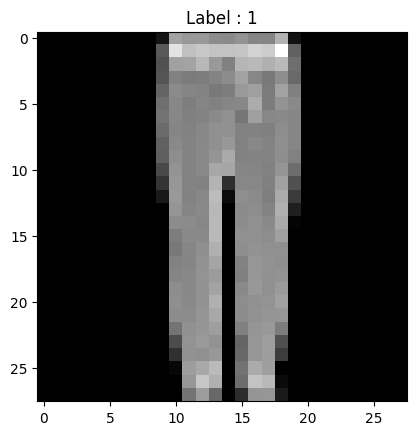

In [12]:
i=np.random.choice(len(train_dataset))
img, label = train_dataset[i]

plt.imshow(img.squeeze(), cmap="gray")
plt.title(f"Label : {label}")
plt.show()

We provide here a global set up, valable for different dataset.

In [15]:
class CVAEFashionMNIST(Dataset):
    def __init__(self, root, train=True, transform=None, download=False):
        # Load FashionMNIST
        self.original = FashionMNIST(root, train=train, download=download)
        self.transform = transform

    def __len__(self):
        return len(self.original)

    def __getitem__(self, item):
        image, digit = self.original[item]

        # Create sample dict
        sample = {'original': image, 'digit': digit}

        # Apply transform to the whole sample
        if self.transform:
            sample = self.transform(sample)

        return sample
class ToTensor:
    def __call__(self, sample):
        # Convert image to tensor
        sample['original'] = functional.to_tensor(sample['original'])

        # Convert label to tensor
        sample['digit'] = torch.as_tensor(
            np.asarray(sample['digit']),
            dtype=torch.int64
        )
        return sample
    
class MaskImages:
    """
    This image transformation masks MNIST/FashionMNIST images by removing
    specific quadrants depending on the number of input quadrants used (1, 2, or 3).
    The removed quadrants are filled with 'mask_with'. 
    The complementary area becomes the input.
    """

    def __init__(self, num_quadrant_inputs, mask_with=-1):
        if num_quadrant_inputs <= 0 or num_quadrant_inputs >= 4:
            raise ValueError("num_quadrant_inputs must be 1, 2, or 3")
        self.num = num_quadrant_inputs
        self.mask_with = mask_with

    def __call__(self, sample):
        tensor = sample['original'].squeeze()
        out = tensor.detach().clone()
        h, w = tensor.shape

        # Always remove bottom-left quadrant from output
        out[h // 2:, :w // 2] = self.mask_with

        # Remove top-left quadrant if only 2 quadrants are kept
        if self.num == 2:
            out[:, :w // 2] = self.mask_with

        # Remove top-right quadrant if only 1 quadrant is kept
        if self.num == 3:
            out[:h // 2, :] = self.mask_with

        # Build input as the complementary of output
        inp = tensor.clone()
        inp[out != -1] = self.mask_with

        sample['input'] = inp
        sample['output'] = out
        return sample
class Compose:
    """Applies a list of transforms to the sample dict, in order."""
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, sample):
        for t in self.transforms:
            sample = t(sample)
        return sample

def get_data(num_quadrant_inputs, batch_size):

    # Use custom Compose instead of torch.nn.Sequential
    transforms = Compose([
        ToTensor(),
        MaskImages(num_quadrant_inputs=num_quadrant_inputs)
    ])

    datasets = {}
    dataloaders = {}
    dataset_sizes = {}

    for mode in ['train', 'val']:
        datasets[mode] = CVAEFashionMNIST(
            root='../data',
            train=(mode == 'train'),
            download=True,
            transform=transforms
        )

        dataloaders[mode] = torch.utils.data.DataLoader(
            datasets[mode],
            batch_size=batch_size,
            shuffle=(mode == 'train'),
            num_workers=0
        )

        dataset_sizes[mode] = len(datasets[mode])

    return datasets, dataloaders, dataset_sizes

def visualize_batch(dataloader, n=8):
    # Get a batch from dataloader
    batch = next(iter(dataloader))
    inputs = batch["input"]
    outputs = batch["output"]
    labels = batch["digit"]

    # Prepare grid
    fig, axes = plt.subplots(n, 3, figsize=(8, 2*n))
    fig.suptitle("Input Mask   |   Output Mask   |   Label", fontsize=14)

    for i in range(n):
        # Input masked
        axes[i, 0].imshow(inputs[i], cmap="gray")
        axes[i, 0].set_title("Input")
        axes[i, 0].axis("off")

        # Output masked
        axes[i, 1].imshow(outputs[i], cmap="gray")
        axes[i, 1].set_title("Output")
        axes[i, 1].axis("off")

        # Label text
        axes[i, 2].text(0.5, 0.5, f"{labels[i].item()}",
                        fontsize=18, ha="center", va="center")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()


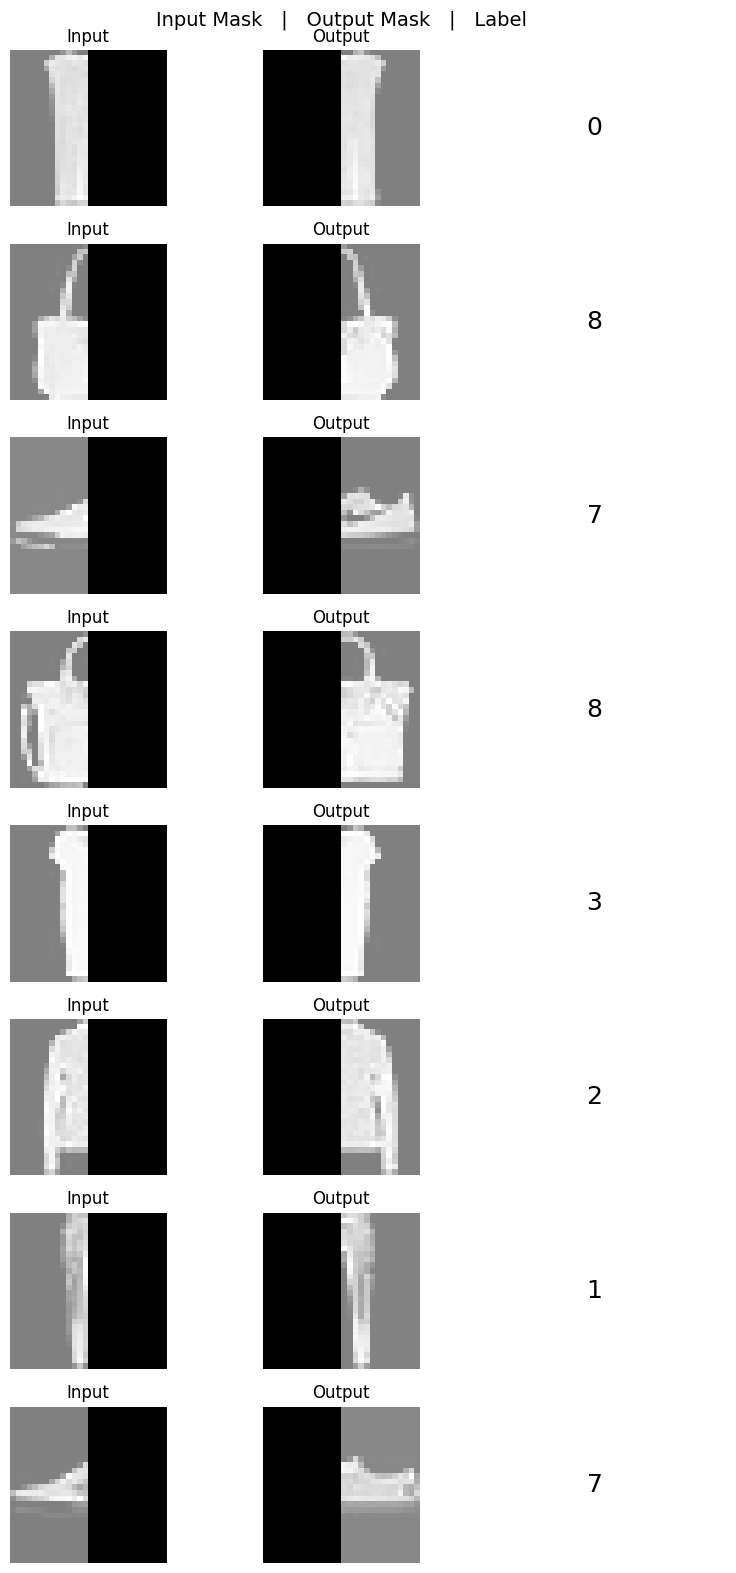

In [18]:
datasets, dataloaders, sizes = get_data(num_quadrant_inputs=2, batch_size=16)

# Visualize training data
visualize_batch(dataloaders["train"], n=8)

In [20]:
class BaselineNet(nn.Module):
    def __init__(self, hidden_1, hidden_2):
        super().__init__()
        self.fc1 = nn.Linear(784, hidden_1)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.fc3 = nn.Linear(hidden_2, 784)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 784)
        hidden = self.relu(self.fc1(x))
        hidden = self.relu(self.fc2(hidden))
        y = torch.sigmoid(self.fc3(hidden))
        return y

In [ ]:
class MaskedBCELoss(nn.Module):
    def __init__(self, masked_with=-1):
        super().__init__()
        self.masked_with = masked_with

    def forward(self, input, target):
        target = target.view(input.shape)
        loss = F.binary_cross_entropy(input, target, reduction='none')
        loss[target == self.masked_with] = 0
        return loss.sum()